In [ ]:
''' Retrive data from Tuya Cloud API '''
import os
from numpy import save
import pandas as pd
from pkgutil import get_data
from datetime import datetime, timedelta
import re
import time
import hmac
import hashlib
import requests
import json
import tqdm
from yarg import get

# 替换Postman参数
def replace_evironment_params(replace):
    # while "{{" in str and "}}" in str:
    #     key = str[str.index("{{") + 2:str.index("}}")]
    #     value = pm.environment.get(key, "")
    #     str = str.replace("{{" + key + "}}", value)
    # repalce the 
    return replace

# 转换为JSON对象
def to_json_obj(params, arr, map_params):
    json_body = json.loads(json.dumps(params))
    for item in json_body:
        arr.append(item["key"])
        map_params[item["key"]] = item["value"]

# 获取当前时间戳
def get_time():
    return int(time.time() * 1000)

# 令牌验签计算
def calc_access_sign(client_id, timestamp, nonce, sign_str, secret):
    str_to_sign = client_id + str(timestamp) + nonce + sign_str
    hash_obj = hmac.new(secret.encode(), str_to_sign.encode(), hashlib.sha256)
    sign_up = hash_obj.hexdigest().upper()
    return sign_up

# 业务验签计算
def calc_sign(client_id, access_token, timestamp, nonce, sign_str, secret):
    str_to_sign = client_id + access_token + str(timestamp) + nonce + sign_str
    hash_obj = hmac.new(secret.encode(), str_to_sign.encode(), hashlib.sha256)
    sign_up = hash_obj.hexdigest().upper()
    return sign_up

# 生成签名字符串
def string_to_sign(query, mode, method, secret, url, headers):
    sha256 = ""
    url_str = ""
    headers_str = ""
    body_str = ""


    # if mode:
    #     if mode != "formdata" and mode != "urlencoded":
    #         body_str = replace_postman_params(json.dumps(pm.request.body))
    #     elif mode == "formdata":
    #         to_json_obj(pm.request.body["formdata"], arr, map_params)
    #     elif mode == "urlencoded":
    #         to_json_obj(pm.request.body["urlencoded"], arr, map_params)

    sha256 = hashlib.sha256(body_str.encode()).hexdigest()
 
    # 将query中的 key 和 value 拼接成字符串，url_str += key + "=" + value + "&", query 是list
    for item in query:
        for key, value in item.items():
            url_str += key + "=" + value + "&"

    if url_str:
        url_str = url_str[:-1]
        url_str = "/" + "/".join(url['path']) + "?" + url_str
    else:
        url_str = "/" + "/".join(url['path'])

    if "Signature-Headers" in headers:
        sign_header_str = headers["Signature-Headers"]
        sign_header_keys = sign_header_str.split(":")
        for item in sign_header_keys:
            val = headers.get(item, "")
            headers_str += item + ":" + val + "\n"

    sign_url = method + "\n" + sha256 + "\n" + headers_str + "\n" + url_str

    return {"signUrl": sign_url, "url": url_str}

# pre_request
def pre_request():
    timestamp = get_time()
    environment["timestamp"] = timestamp

    client_id = environment.get("client_id")
    secret = environment.get("secret")
    access_token = environment["easy_access_token"]

    http_method = environment['request']['method'].upper()
    query = environment['request']['url']['query']
    mode = environment['request']['body']['mode']
    headers = environment['request']['headers']

    sign_map = string_to_sign(query, mode, http_method, secret, environment['request']['url'], headers)
    url_str = sign_map["url"]
    sign_str = sign_map["signUrl"]
    environment['request']['url']['url'] = environment['request']['url']['host'] + url_str

    nonce = headers["nonce"]
    
    if access_token:
        sign = calc_sign(client_id, access_token, timestamp, nonce, sign_str, secret)
        environment['easy_sign'] = sign
        environment['request']['headers']['sign'] = sign
    else:
        sign = calc_access_sign(client_id, timestamp, nonce, sign_str, secret)
        environment['easy_sign'] = sign
        environment['request']['headers']['sign'] = sign

# 获取 easy_access_token
def get_access_token():
    url = environment['request']['url']['url']
    headers = environment['request']['headers']    
    # 生成签名字符串
    headers['t'] = str(get_time())
    # 发起请求
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        try:
            access_token = data['result']['access_token']
            environment["easy_access_token"] = access_token
            return access_token
        except KeyError as e:
            print(f"Failed to retrieve access token.\n  Response Text: {response.text}\n  Error: {e}")
        print(f"Failed to get access token.\n  Response Text: {response.text}\n  Status Code: {response.status_code}")
    return None


def save_data(raw_data):
    # 提取 eventTime 和 value
    logs = []
    for log in raw_data:
        event_time = log['eventTime']
        value = log['value']
        # 将 eventTime 转换为日期时间
        timestamp = datetime.utcfromtimestamp(event_time / 1000)  # 转换为秒
        formatted_time = timestamp.strftime('%Y-%m-%d %H:%M:%S')
        logs.append({"eventTime": formatted_time, "value": value})
    
    # 将数据转换为 DataFrame
    df = pd.DataFrame(logs)
    
    # 生成文件名，以事件时间的最早和最晚时间命名
    start_time = df['eventTime'].iloc[0]
    end_time = df['eventTime'].iloc[-1]
    
    # 替换非法字符
    start_time = start_time.replace(":", "_")
    end_time = end_time.replace(":", "_")
    
    file_name = f"{save_dir}\\{start_time} - {end_time}.xlsx"
    
    # 保存为 Excel 文件
    df.to_excel(file_name, index=False)
    print(f"Data saved to {file_name}")
    return

# retrive data
def retrive_data():
    url = environment['request']['url']['url']
    headers = environment['request']['headers']
    headers['t'] = str(get_time())
    # 发起请求
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        try:
            save_data(data['result']['logs'])
            return True
        except KeyError as e:
            print(f"Failed to retrieve data:\n  Response Text: {response.text}\n    Error: {e}")
            return False
    else:
        print(f"Failed to retrieve data:\n  Response Text: {response.text}\n    Status Code: {response.status_code}")
        return False

def check_failed_timestamps():
    """检查是否有失败的时间戳，并返回"""
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            failed_logs = f.readlines()
        # Convert logs to a list of dictionaries with start_time and end_time
        return [log.strip() for log in failed_logs]
    return []

def save_failed_timestamp(start_time, end_time):
    """保存失败的时间戳到日志"""
    failed_logs = check_failed_timestamps()
    failed_logs.append(f"{start_time} {end_time}")
    with open(log_file, 'w') as f:
        for log in failed_logs:
            f.write(log + "\n")

def retrive_data_with_retry(start_time, end_time, retries=3):
    """对失败的时间戳进行重试（后面太浪费api请求次数了，这个部分没调用）"""
    for attempt in range(retries):
        print(f"Attempt {attempt + 1} to retrieve data from {start_time} to {end_time}")
        environment['request']['url']["query"] = [
            {
                "codes": "cur_power",
                "end_time": str(end_time),
                "size": "100",
                "start_time": str(start_time)
            }
        ]
        pre_request()
        success = retrive_data()
        if success:
            return True
        else:
            print(f"Retrieval failed for {start_time} to {end_time}. Retrying...")
    print(f"Failed to retrieve data after {retries} attempts: {start_time} to {end_time}")
    # save_failed_timestamp(start_time, end_time)
    return False

def main(main_start_time, main_end_time):
    # get access token
    pre_request()
    success = get_access_token()
    if not success:
        print("Initialization failed.")
        return
    else:
        print("Initialization success.\n")
        
    # upadata the request
    request = environment['request']
    request['url']["path"] = ["v2.1", "cloud", "thing", environment["device_id"], "report-logs"]
    request['url']['url'] = ""
    request['headers'] = {
        "client_id": "fhtp59vtgqy993wc7xww",
        "access_token": environment["easy_access_token"],
        "sign": environment["easy_sign"],
        "sign_method":"HMAC-SHA256",
        "t": "",
        "nonce":"",
        "stringToSign": ""
    }
    environment['request'] = request
    
    # Convert main_start_time and main_end_time to timestamps
    start_time = datetime.strptime(main_start_time, "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(main_end_time, "%Y-%m-%d %H:%M:%S")
    print(f"Retrieving data from {start_time} to {end_time}")
    
    # Calculate number of time intervals (half hour intervals)
    interval = timedelta(minutes=30)
    runtime = int((end_time - start_time) / interval)

    # Get failed timestamps from the log file
    failed_logs = check_failed_timestamps()
    print(f"Failed logs: {failed_logs}")

    # Get failed timestamps from the log file
    failed_logs = check_failed_timestamps()

    # Loop through each time interval
    for i in tqdm.tqdm(range(runtime)):
        query_start_time = start_time + i * interval
        query_end_time = query_start_time + interval

        # Convert start_time and end_time to timestamps in milliseconds
        query_start_timestamp = int(query_start_time.timestamp() * 1000)
        query_end_timestamp = int(query_end_time.timestamp() * 1000)
        # print(f"Querying data from {query_start_timestamp} to {query_end_timestamp}")
        # break

        # Check if the timestamp is already in the failed log, if so, retry first
        if any(f"{query_start_timestamp} {query_end_timestamp}" == log for log in failed_logs):
            print(f"Retrying failed timestamp: {query_start_time} to {query_end_time}")
            success = retrive_data_with_retry(query_start_timestamp, query_end_timestamp)
            if not success:
                continue

        # Check if the timestamp has been processed before to avoid duplication
        elif os.path.exists(log_file) and f"{query_start_timestamp} {query_end_timestamp}" in open(log_file).read():
            print(f"Skipping already processed timestamp: {query_start_time} to {query_end_time}")
            continue

        else:
            print(f"Querying data from {query_start_time} to {query_end_time}")
            environment['request']['url']["query"] = [
                {
                    "codes": "cur_power",
                    "end_time": str(query_end_timestamp),
                    "size": "100",
                    "start_time": str(query_start_timestamp)
                }
            ]
            pre_request()
            success = retrive_data()
            if not success:
                print(f"Failed to retrieve data for {query_start_time} to {query_end_time}")
                # save_failed_timestamp(query_start_timestamp, query_end_timestamp)
            else:
                print(f"Data saved for {query_start_time} to {query_end_time}")


if __name__ == "__main__":
    #intialize
    # save_dir = "D:\\Desktop\\Mppt_cur_power"
    
    divce_dict = {
        "十五舍": "",
        "专教": ""
    }

    # retrive data in certain time
    main_start_time = "2025-06-16 05:00:00"
    main_end_time = "2025-06-17 19:00:00"


    for key, value in divce_dict.items():
        print(f"Retrieving data for {key}")
        print(f"Device ID: {value}")
        
        pre_fix = key
        # pre_fix = "十五舍"
        # pre_fix = "专教"
        save_dir = f"D:\\Desktop\\Mppt_cur_power\\{pre_fix}"
        log_file = f"D:\\Desktop\\Mppt_cur_power\\{pre_fix}\\failed_logs.txt"


        environment = {
            "url": "https://openapi.tuyacn.com",
            "client_id": "",
            "secret": "",
            "device_id": value,
            "timestamp": "",
            "easy_access_token": "",
            "easy_sign": "",
            "request": {
                "url": {
                    "host": "https://openapi.tuyacn.com",
                    "path": ["v1.0", "token"],
                    "query": [
                        {
                            "grant_type": "1"
                        }
                    ],
                    "variable":"",
                    "url":""
                },
                "headers":{
                        "client_id": "fhtp59vtgqy993wc7xww",
                        "sign": "",
                        "sign_method":"HMAC-SHA256",
                        "t": "",
                        "nonce":"",
                        "stringToSign": ""
                },
                "method": "GET",
                "body": {
                    "mode": ""
                },
            }
        }
        main(main_start_time, main_end_time)

----------------------------  Processing 十五舍  ----------------------------
Preprocessing 十五舍 data......
Preprocessing 十五舍 data finished!


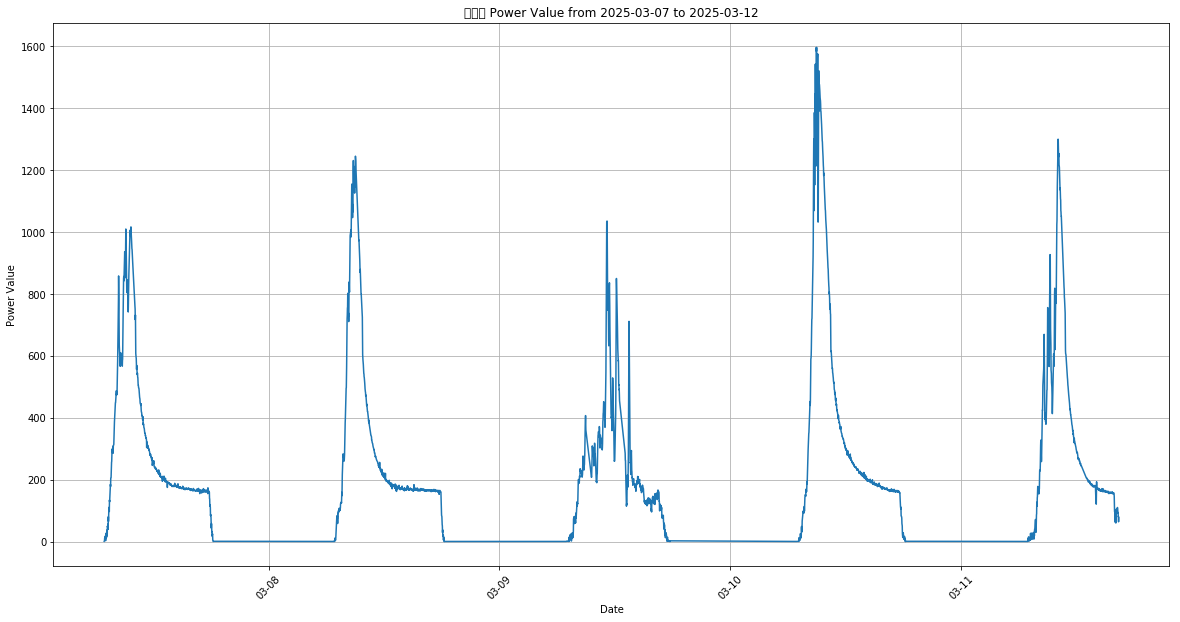

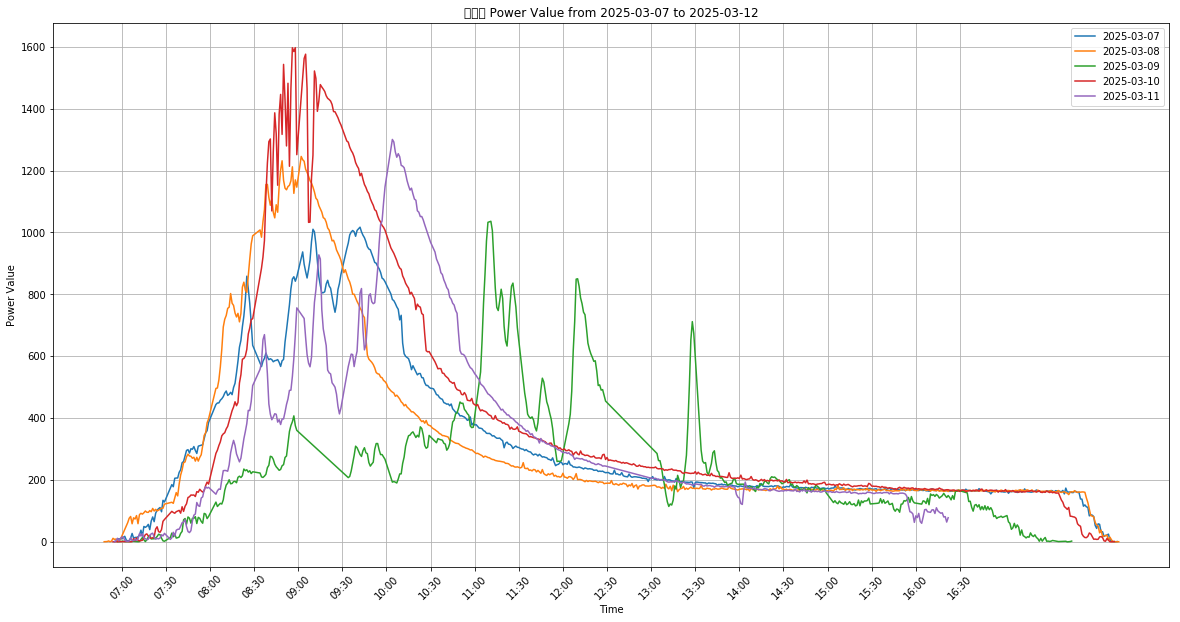

----------------------------  Processing 专教  ----------------------------
Preprocessing 专教 data......
Preprocessing 专教 data finished!


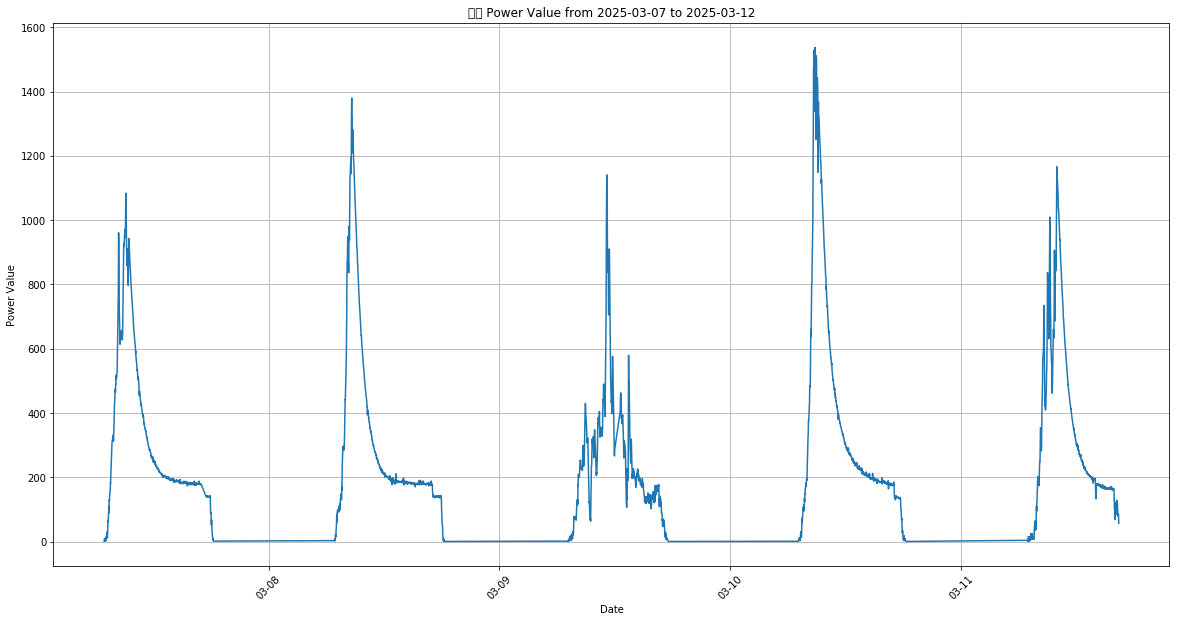

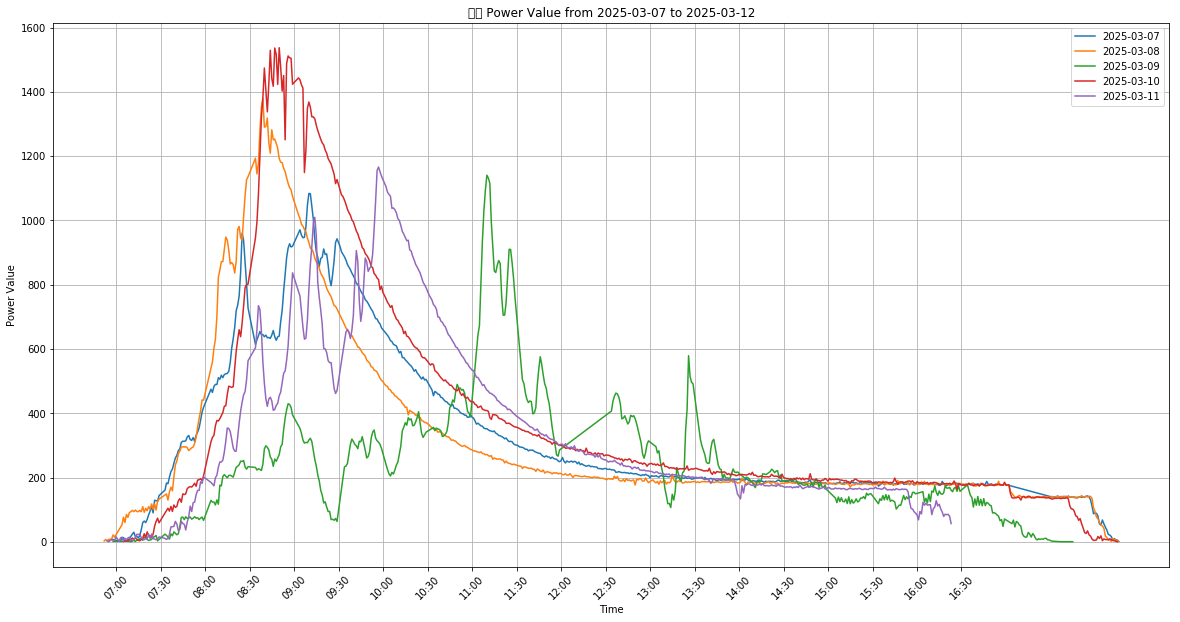

In [33]:
'''Preprocessing and Visualizing Data'''
import os
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def preprocess_data(pre_fix, extracted_raw_data_dir, filtered_data_dir):

    # 读取所有 .xlsx 文件并处理
    excel_files = [f for f in os.listdir(extracted_raw_data_dir) if f.endswith('.xlsx')]   
    raw_df = pd.DataFrame()
    print (f"Reading {pre_fix} data......")
    # 更正 eventTime 列的时间偏移+8小时， eventTime 的格式为 "%Y-%m-%d %H:%M:%S" ，例如2025-03-10 03:29:33， 加了8小时如果超过24小时，日期也要加1天
    for file in excel_files:
        file_path = os.path.join(extracted_raw_data_dir, file)
        df = pd.read_excel(file_path)
        df['eventTime'] = pd.to_datetime(df['eventTime']) + pd.Timedelta(hours=8)
        # 将时间精确到分钟，去掉秒
        df['eventTime'] = df['eventTime'].dt.strftime('%Y-%m-%d %H:%M')
        # 查重，相同的分钟取平均值
        df = df.groupby('eventTime').mean().reset_index()
        raw_df = pd.concat([raw_df, df], ignore_index=True)

    print (f"Reading {pre_fix} data finished!")

    # 确保 eventTime 列是 datetime 类型
    raw_df['eventTime'] = pd.to_datetime(raw_df['eventTime'], errors='coerce')
    # 查重，删除重复eventTime的行
    raw_df = raw_df.drop_duplicates(subset=['eventTime'])
    # 按照 eventTime 中的日期分组，每组数据保存为一个新的 Excel 文件
    for name, group in tqdm(raw_df.groupby(raw_df['eventTime'].dt.date), desc=f"Dispatching {pre_fix}"):
        file_name = os.path.join(filtered_data_dir, f"{name}.xlsx")
        group = group.sort_values(by='eventTime')
        group.to_excel(file_name, index=False, encoding='utf-8-sig')


def visualize_data(filtered_data_dir, pre_fix, visual_start_time, visual_end_time):
    # 可视化 visual_start_time 到 visual_end_time 之间的数据
    visual_df = pd.DataFrame()
    for file in os.listdir(filtered_data_dir):
        file_path = os.path.join(filtered_data_dir, file)
        df = pd.read_excel(file_path)
        visual_df = pd.concat([visual_df, df], ignore_index=True)
    visual_df['eventTime'] = pd.to_datetime(visual_df['eventTime'])
    visual_df = visual_df[(visual_df['eventTime'] >= visual_start_time) & (visual_df['eventTime'] <= visual_end_time)]
    
    # 图1：x轴为不同的日期，y轴为功率值
    visual_df['date'] = visual_df['eventTime'].dt.date
    visual_df = visual_df.sort_values(by='eventTime')

    ## 绘制折线图1
    plt.figure(figsize=(20, 10))
    plt.plot(visual_df['eventTime'], visual_df['value'])
    plt.xlabel('Date')
    plt.ylabel('Power Value')
    plt.title(f'{pre_fix} Power Value from {visual_start_time} to {visual_end_time}')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.grid()
    plt.show()

    # 图2：x轴为不同的日期+相同的时间，y轴为功率值
    visual_df['time'] = visual_df['eventTime'].dt.time
    visual_df = visual_df.sort_values(by=['date', 'time'])

    ## 绘制折线图2
    plt.figure(figsize=(20, 10))
    for date, group in visual_df.groupby('date'):
        plt.plot(group['time'], group['value'], label=date)
    plt.xlabel('Time')
    plt.ylabel('Power Value')
    plt.title(f'{pre_fix} Power Value from {visual_start_time} to {visual_end_time}')
    time_labels = pd.date_range(start='7:00', end='16:59', freq='30T').time
    time_labels_str = [t.strftime('%H:%M') for t in time_labels]
    plt.xticks(time_labels_str, rotation=45)
    plt.legend()
    plt.grid()
    plt.show()



def main(pre_fix, extracted_dir):

    extracted_raw_data_dir = os.path.join(extracted_dir, pre_fix)
    filtered_data_dir = os.path.join(extracted_dir, pre_fix, "filtered")
    if not os.path.exists(filtered_data_dir):
        os.makedirs(filtered_data_dir)

    # 预处理数据
    print (f"Preprocessing {pre_fix} data......")
    # preprocess_data(pre_fix, extracted_raw_data_dir, filtered_data_dir)
    print (f"Preprocessing {pre_fix} data finished!")

    visual_start_time = '2025-03-07'
    visual_end_time = '2025-03-12'

    # 可视化数据
    visualize_data(filtered_data_dir, pre_fix, visual_start_time, visual_end_time)



if __name__ == "__main__":
    prefix_list = ["十五舍", "专教"]
    extracted_dir = "D:\\Desktop\\Mppt_cur_power"
    for pre_fix in prefix_list:
        print (f"----------------------------  Processing {pre_fix}  ----------------------------")
        main(pre_fix, extracted_dir)